## Explainable Evidential Clustering

In [300]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [301]:
# Load the csv file
df = pd.read_csv('data/easy_synth_data.csv')

feature_names = df.columns[:-1].to_list()
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values
classes = np.unique(labels)

In [302]:
def plot_soft_clustering(memberships, title, legend=None, fig=None):
    N = memberships.shape[1]
    
    if fig == None:
        fig = plt.figure(figsize=(8, 8))

    # get list of colors 
    cmap = plt.get_cmap('Set1')

    for point in range(len(features)):
        color = np.sum([np.array(cmap(i)) * memberships[point, i] for i in range(N)], axis=0)
        color = np.clip(color, 0, 1)

        plt.scatter(features[point, 0], features[point, 1], c=[color], edgecolors='k')

    plt.title(title)

    if legend == None:
        legend = ['$\\omega_{' + str(i+1) + '}$' for i in range(N)]
    if len(legend) > 0:
        fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=legend[i], 
                                    markerfacecolor=cmap(i), markersize=10) for i in range(len(legend))],edgecolor='black', 
                loc='lower center', ncol=len(legend), fontsize='large', title='metacluster', bbox_to_anchor=(0.5, 0))
        
        plt.subplots_adjust(bottom=0.2)
                
    plt.show()

## Evidential C-Means Clustering

In [303]:
# ECM clustering
from evclust.ecm import ecm
model = ecm(x=features, c=2, beta = 1.3,  alpha=1, delta=3, disp=False)

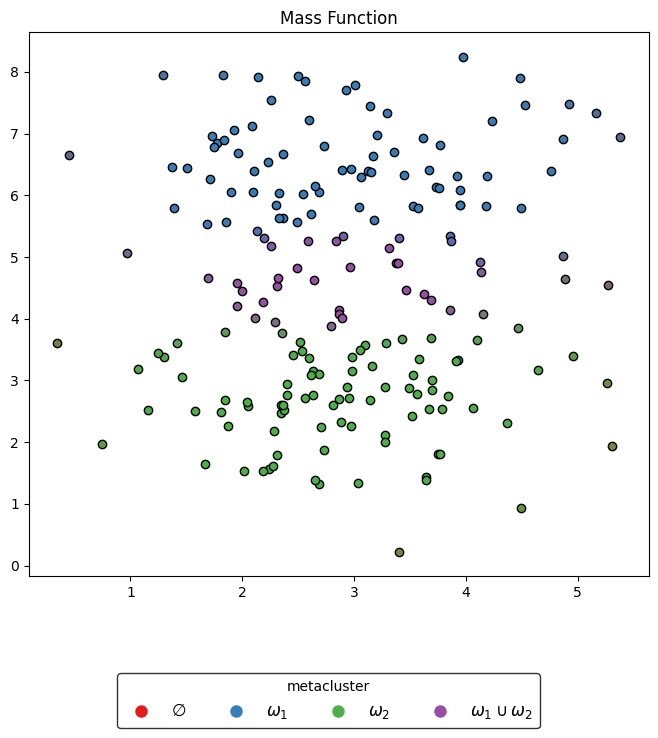

In [304]:
F = model['F']


focal_sets = [" \\cup ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1]) for f in F]
focal_sets[0] = "\emptyset"
focal_sets = ['$'+f+'$' for f in focal_sets]

mass = model['mass']
plot_soft_clustering(mass, 'Mass Function', legend=focal_sets)

In [305]:
def plot_parameters(alpha, beta, delta, ax, name):
    model = ecm(x=features, c=2, beta = beta,  alpha=alpha, delta=delta, disp=False)
    memberships = model['mass']
    N = memberships.shape[1]

    # get list of colors 
    cmap = plt.get_cmap('Set1')

    ax.set_yticks([])
    ax.set_xticks([])

    for point in range(len(features)):
        color = np.sum([np.array(cmap(i)) * memberships[point, i] for i in range(N)], axis=0)
        color = np.clip(color, 0, 1)
    
        ax.scatter(features[point, 0], features[point, 1], c=[color], edgecolors='k')

    ax.set_title(f'{name}\n($\\alpha={alpha}$, $\\beta={beta}$, $\\delta={delta}$)')

In [306]:
# fig, axs = plt.subplots(2, 3, figsize=(10, 6.66))

# pars = [
#     (10, 1.01, 10),
#     (10, 2, 10),
#     (10, 1.7, 3),
#     (1, 1.01, 3),
#     (1, 1.4, 3),
# ]

# name = [
#     '(quasi-)Hard Clustering',
#     '(quasi-)Fuzzy Clustering',
#     '(quasi-)Possibilistic Clustering',
#     '(quasi-)Rough Clustering',
#     'Evidential Clustering',
# ]

# # scatter in gray
# for point in range(len(features)):
#     axs[0, 0].scatter(features[point, 0], features[point, 1], c='gray', edgecolors='k')
#     axs[0, 0].set_yticks([])
#     axs[0, 0].set_xticks([])
#     axs[0, 0].set_title('Original Data Distribution')

# for i in range(len(pars)):
#     i +=1
#     plot_parameters(*pars[i-1], axs[i//3, i%3], name[i-1])

# fig.suptitle('ECM Clustering Output ($C=2$, $X \in \mathbb{R}^2$) with different parameters', fontsize=14)

# fig.tight_layout()

# fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=focal_sets[i], 
#                                     markerfacecolor=plt.get_cmap('Set1')(i), markersize=10) for i in range(len(focal_sets))],edgecolor='black', 
#                 loc='lower center', ncol=len(focal_sets), fontsize='large', title='meta-clusters ($F = 2^\Omega$)', bbox_to_anchor=(0.5, -0.1))
        

# export the plot as a pdf
#plt.savefig('figs/ECM_clustering.pdf', bbox_inches='tight')


## XEDTs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


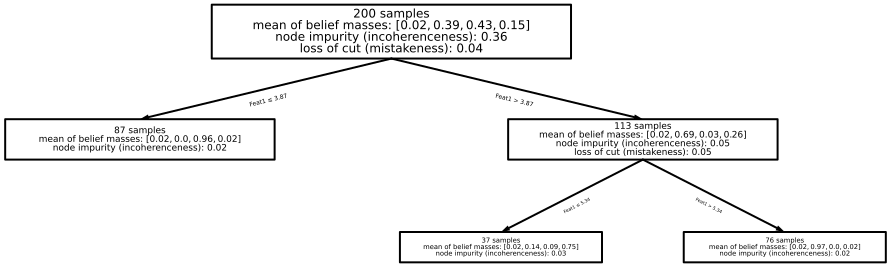

In [406]:
%load_ext autoreload
%autoreload 2

from lib.xedt import XEDT, Loss

xedt = XEDT(max_depth=3)
xedt.fit(X=features, mass=model['mass'], F=model['F'])

xedt.plot_tree()

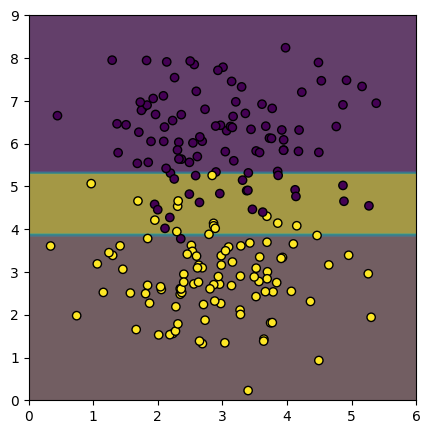

In [399]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

X, Y = np.meshgrid(np.linspace(0, 6, 100), np.linspace(0, 9, 100))
features_xy = np.column_stack((X.ravel(), Y.ravel()))
Z_mass = xedt.predict(features_xy, return_bba=True)[1].reshape(X.shape[0], X.shape[1], -1)

for i in range(Z_mass.shape[2]):
    ax.contourf(X, Y, Z_mass[:, :, i], alpha=0.5, cmap='viridis')

ax.scatter(features[:, 0], features[:, 1], c=labels, edgecolors='k', cmap='viridis')

/var/folders/qn/sypqqw3101v1k6_70wqyd99h0000gn/T/ipykernel_84644/4093130914.py:8: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(features[point, 0], features[point, 1], c='red', edgecolors='k', marker='x')


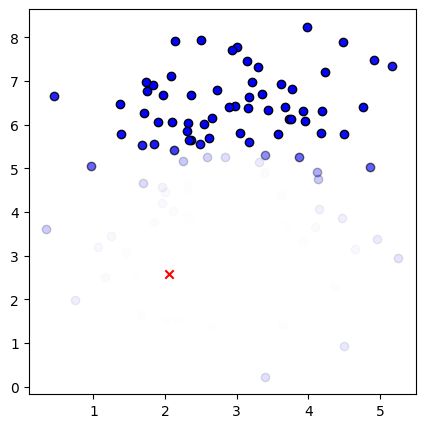

In [309]:
function_incoherenceness = Loss.incoherenceness(bel=model['bel'], pl=model['pl'])

point = 50

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# as x
ax.scatter(features[point, 0], features[point, 1], c='red', edgecolors='k', marker='x')

for j in range(features.shape[0]):
    if not point > j:
        membership = function_incoherenceness(point, j)

        ax.scatter(features[j, 0], features[j, 1], c='blue', edgecolors='k', alpha=membership)

In [310]:
metacluster_centroids = []
for i in range(len(model['F'])):
    if np.sum(model['F'][i]) > 0:
        centroid = np.zeros(2)
        for point in range(len(features)):
            centroid += features[point] * model['mass'][point, i]
        centroid /= np.sum(model['mass'][:, i])
        metacluster_centroids.append(centroid)
metacluster_centroids = np.array(metacluster_centroids)

In [311]:
metacluster_centroids

array([[2.95841999, 6.46996078],
       [2.88758197, 2.71288954],
       [2.88970531, 4.59652246]])

In [312]:
F

array([[0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 1.]])

(4,)


TypeError: mistakeness() missing 2 required positional arguments: 'missing_metacluster_idxs' and 'powered_jaccard_matrix'

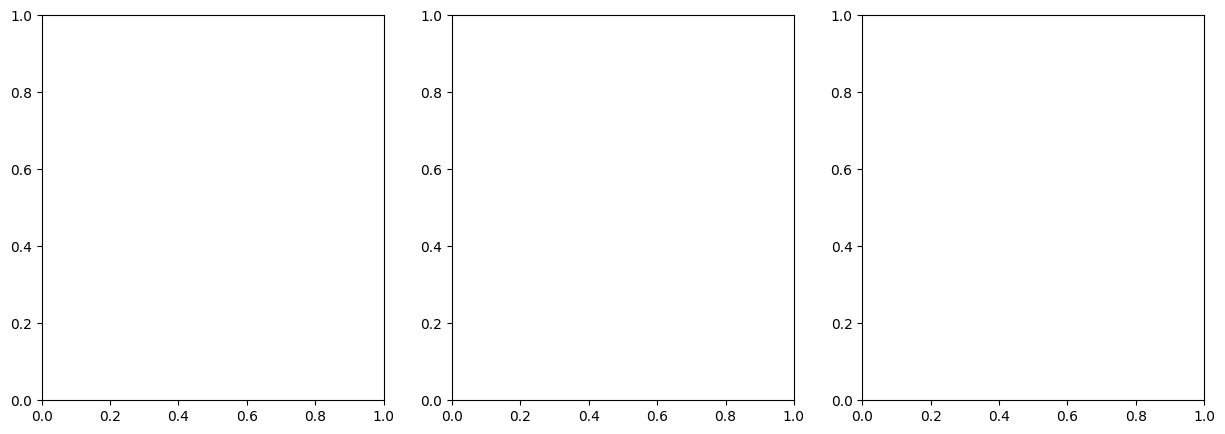

In [400]:
mass = model['mass']

print(mass[point, :].shape)

fig, ax = plt.subplots(1, metacluster_centroids.shape[0], figsize=(5 * metacluster_centroids.shape[0], 5))

for i in range(metacluster_centroids.shape[0]):
    for point in range(len(features)):
        lacking = list(set(range(metacluster_centroids.shape[0])) - {i})
        lacking = np.array(lacking) + 1
        mistakeness = Loss.mistakeness(mass[point, :].reshape(1,-1), lacking)

        mistakeness = np.clip(mistakeness, 0, 1)

        ax[i].scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], c='green', edgecolors='k', marker='x')
        ax[i].scatter(features[point, 0], features[point, 1], c='red', edgecolors='k', alpha=mistakeness)